In [2]:
using AutomotiveDrivingModels
using AutoScenes
using Records
using PGFPlots

include("../AutoMobius/AutoMobius.jl")
using AutoMobius

In [3]:
const TIMESTEP = 0.1
const RISK_THRESHOLD = 0.25
const OUTPUT_FILE_SUFFIX = "0925"


"0925"

In [5]:
println("loading risk estimations")
tic()
risk_ests = let
    io = open("../data/risks_"*OUTPUT_FILE_SUFFIX*".txt", "r")
    risks = Float64[]
    while !eof(io)
        line = readline(io)
        push!(risks, parse(Float64, strip(line)))
    end
    risks
    # lines = readlines("data/risks_"*OUTPUT_FILE_SUFFIX*".txt")
    # betas = Array{Beta}(length(lines))
    # for (i,line) in enumerate(lines)
    #     tokens = split(strip(line), ", ")
    #     α = parse(Float64, tokens[1])
    #     β = parse(Float64, tokens[2])
    #     betas[i] = Beta(α, β)
    # end
    # betas
end
toc()

loading risk estimations
elapsed time: 198.459250581 seconds


198.459250581

In [37]:
crit_scene_end_ticks = Int[]

println("loading crit scenarios")
tic()
data_dir = "../data/collision_scenarios"
for file in readdir(data_dir)
    if ismatch(r"collision_listrecord_tick_\d+_datetime_\d+_\d+_\d+.txt", file)
        filepath = joinpath(data_dir, file)
        tick = parse(Int, match(r"(?<=tick_)\d+", file).match)
        tick += 1
        while !(risk_ests[tick] > RISK_THRESHOLD && risk_ests[tick+1] < RISK_THRESHOLD)
            tick += 1
        end
        push!(crit_scene_end_ticks, tick)
    end
end
crit_scene_end_ticks = unique(crit_scene_end_ticks)
toc()

loading crit scenarios
elapsed time: 0.592426545 seconds


0.592426545

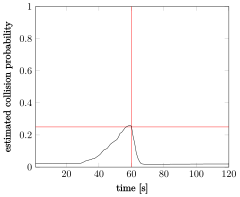

In [40]:
scene_index = 3
risks = risk_ests[crit_scene_end_ticks[scene_index]-59 : crit_scene_end_ticks[scene_index]+60]
Axis([
    Plots.Linear([1, length(risks)], [0.25, 0.25], style="solid, red, mark=none"),
    Plots.Linear([60, 60], [0, 1], style="solid, red, mark=none"),
    Plots.Linear(collect(1:length(risks)), risks, style="solid, black, mark=none"),
    ],
    xlabel="time [s]", ylabel="estimated collision probability",
    ymin=0, ymax=1, style="enlarge x limits=0",
)

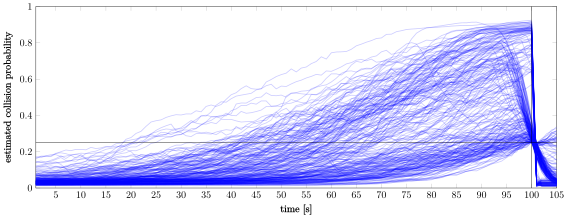

In [53]:
t_rear = 100

srand(0)
plots = Plots.Plot[]
for i in randperm(length(crit_scene_end_ticks))[1:250]
    risks = risk_ests[crit_scene_end_ticks[i]-(t_rear-1) : crit_scene_end_ticks[i]+5]
    push!(plots, Plots.Linear(collect(1:length(risks)), risks, style="solid, thick, blue, opacity=0.20, mark=none"))
end

push!(plots, Plots.Linear([1, length(risks)], [0.25, 0.25], style="solid, black, mark=none"))
push!(plots, Plots.Linear([t_rear, t_rear], [0, 1], style="solid, black, mark=none"))

ax = Axis(plots,
    xlabel="time [s]", ylabel="estimated collision probability",
    ymin=0, ymax=1, style="enlarge x limits=0",
    width="20cm", height="8cm"
)

In [54]:
save("risk_curve.tex", ax)